In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# -------------------- 1. Load Data --------------------
file_path = r"C:\Users\neeno\Downloads\Supply chain\Supply chain logistics problem.xlsx"
orders = pd.read_excel(file_path, sheet_name="OrderList")

In [38]:
orders.info()
orders.describe()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order ID              9215 non-null   float64       
 1   Order Date            9215 non-null   datetime64[ns]
 2   Origin Port           9215 non-null   object        
 3   Carrier               9215 non-null   object        
 4   TPT                   9215 non-null   int64         
 5   Service Level         9215 non-null   object        
 6   Ship ahead day count  9215 non-null   int64         
 7   Ship Late Day count   9215 non-null   int64         
 8   Customer              9215 non-null   object        
 9   Product ID            9215 non-null   int64         
 10  Plant Code            9215 non-null   object        
 11  Destination Port      9215 non-null   object        
 12  Unit quantity         9215 non-null   int64         
 13  Weight            

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34


In [39]:
# 3. Preprocessing
# ==========================

# Convert 'Order Date' to datetime
orders['Order Date'] = pd.to_datetime(orders['Order Date'], errors='coerce')
orders = orders.dropna(subset=['Order Date'])

# Convert 'Unit quantity' to numeric
orders['Unit quantity'] = pd.to_numeric(orders['Unit quantity'], errors='coerce')
orders = orders.dropna(subset=['Unit quantity'])

# Fill missing quantities (if any)
orders['Unit quantity'] = orders['Unit quantity'].fillna(0)

# Remove duplicates
orders = orders.drop_duplicates()

# Extract only date (optional)
orders['OrderDay'] = orders['Order Date'].dt.date
print("Number of unique days:", orders['OrderDay'].nunique())
print(orders['OrderDay'].value_counts())


Number of unique days: 1929
OrderDay
2013-05-26    4037
2013-06-09      10
2013-05-27      10
2013-06-20      10
2013-06-19      10
              ... 
2017-03-26       1
2017-03-27       1
2017-03-28       1
2017-03-29       1
2017-05-25       1
Name: count, Length: 1929, dtype: int64


In [40]:
# Aggregate unit quantity per day
daily_demand = orders.groupby('OrderDay')['Unit quantity'].sum().reset_index()
daily_demand.rename(columns={'OrderDay':'Date'}, inplace=True)
daily_demand = daily_demand.sort_values('Date')

print(daily_demand.head())
print("Total days:", len(daily_demand))


         Date  Unit quantity
0  2013-02-26            410
1  2013-02-27           1402
2  2013-02-28            546
3  2013-03-01            503
4  2013-03-02            439
Total days: 1929


In [55]:
# 3. Chronological train/test split
# ==========================
train_size = int(len(daily_demand)*0.8)
train = daily_demand.iloc[:train_size].copy()
test = daily_demand.iloc[train_size:].copy()


In [56]:
# Ensure datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])


In [95]:
# -------------------- 1. Naive Forecast --------------------
from sklearn.metrics import mean_squared_error
import numpy as np
naive_pred = [train['Unit quantity'].iloc[-1]]*len(test)
mae_naive = mean_absolute_error(test['Unit quantity'], naive_pred)
rmse_naive = np.sqrt(mean_squared_error(test['Unit quantity'], naive_pred))


In [96]:
# -------------------- 2. Moving Average --------------------
window = 7  # 7-day moving average
moving_avg_series = train['Unit quantity'].rolling(window=window).mean()
last_ma = moving_avg_series.iloc[-1]  # last value of MA
ma_pred = [last_ma] * len(test)
mae_ma = mean_absolute_error(test['Unit quantity'], ma_pred)
rmse_ma = np.sqrt(mean_squared_error(test['Unit quantity'], ma_pred))



In [112]:
# 5. Linear Regression with date features
# ==========================
for df in [train, test]:
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek

X_train = train[['day','month','year','dayofweek']]
y_train = train['Unit quantity']
X_test = test[['day','month','year','dayofweek']]
y_test = test['Unit quantity']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_clipped = np.maximum(lr_pred, 0)

mae_lr = mean_absolute_error(y_test, lr_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))


In [98]:
# -------------------- 4. Random Forest --------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results['RandomForest'] = rf_pred



In [99]:
# -------------------- 5. ARIMA --------------------
# Use order=(1,1,1) as a simple start
arima_model = ARIMA(train['Unit quantity'], order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_pred = arima_forecast.values
mae_arima = mean_absolute_error(y_test, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_test, arima_pred))

In [100]:
# -------------------- Evaluation --------------------
evaluation = {}
for model_name, pred in results.items():
    mae = mean_absolute_error(test['Unit quantity'], pred)
    mse = mean_squared_error(test['Unit quantity'], pred)
    evaluation[model_name] = {'MAE': mae, 'MSE': mse}
    
eval_df = pd.DataFrame(evaluation).T
print("Model Evaluation:\n", eval_df)


Model Evaluation:
                         MAE           MSE
Naive           1663.098446  2.321125e+07
MovingAverage   1660.383420  2.390281e+07
RandomForest   12036.093368  4.459731e+08
ARIMA          10286.936196  1.137965e+08


In [101]:
# 9. Evaluation Metrics Table
metrics = pd.DataFrame({
    'Model': ['Naive', 'Moving Average', 'Linear Regression', 'ARIMA'],
    'MAE': [mae_naive, mae_ma, mae_lr, mae_arima],
    'RMSE': [rmse_naive, rmse_ma, rmse_lr, rmse_arima]
})
print("Evaluation Metrics:\n", metrics)


Evaluation Metrics:
                Model           MAE          RMSE
0              Naive   1663.098446   4817.805642
1     Moving Average   1660.383420   4889.049955
2  Linear Regression  13812.264456  17051.988224
3              ARIMA   1656.237108   4839.720851


In [113]:
# 10. Forecast Comparison Table
comparison = test[['Date','Unit quantity']].copy()
comparison['Naive'] = naive_pred
comparison['Moving Average'] = ma_pred
comparison['Linear Regression'] = lr_pred_clipped
comparison['ARIMA'] = arima_pred
print("\nForecast vs Actual (first 10 rows):\n", comparison.head(10))



Forecast vs Actual (first 10 rows):
            Date  Unit quantity  Naive  Moving Average  Linear Regression  \
1543 2017-05-19           1090    762           516.0        7741.656262   
1544 2017-05-20           1258    762           516.0       14307.942798   
1545 2017-05-21            796    762           516.0       20874.229335   
1546 2017-05-22            806    762           516.0           0.000000   
1547 2017-05-23           1285    762           516.0           0.000000   
1548 2017-05-24           1330    762           516.0        1311.762495   
1549 2017-05-25            453    762           516.0        7878.049031   
1550 2017-05-26            262    762           516.0       14444.335568   
1551 2017-05-27           1274    762           516.0       21010.622104   
1552 2017-05-28           1366    762           516.0       27576.908641   

           ARIMA  
1543  550.461624  
1544  599.443507  
1545  650.325073  
1546  697.998826  
1547  761.645875  
1548  670.4

In [114]:
print("Test dates:", test['Date'].head())
print("Test actuals:", y_test.head())
print("Naive forecast:", naive_pred[:5])
print("MA forecast:", ma_pred[:5])
print("LR forecast:", lr_pred[:5])
print("ARIMA forecast:", arima_pred[:5])


Test dates: 1543   2017-05-19
1544   2017-05-20
1545   2017-05-21
1546   2017-05-22
1547   2017-05-23
Name: Date, dtype: datetime64[ns]
Test actuals: 1543    1090
1544    1258
1545     796
1546     806
1547    1285
Name: Unit quantity, dtype: int64
Naive forecast: [762, 762, 762, 762, 762]
MA forecast: [516.0, 516.0, 516.0, 516.0, 516.0]
LR forecast: [ 7741.65626199 14307.94279844 20874.22933489     0.
     0.        ]
ARIMA forecast: [550.46162408 599.44350732 650.32507289 697.99882571 761.6458749 ]


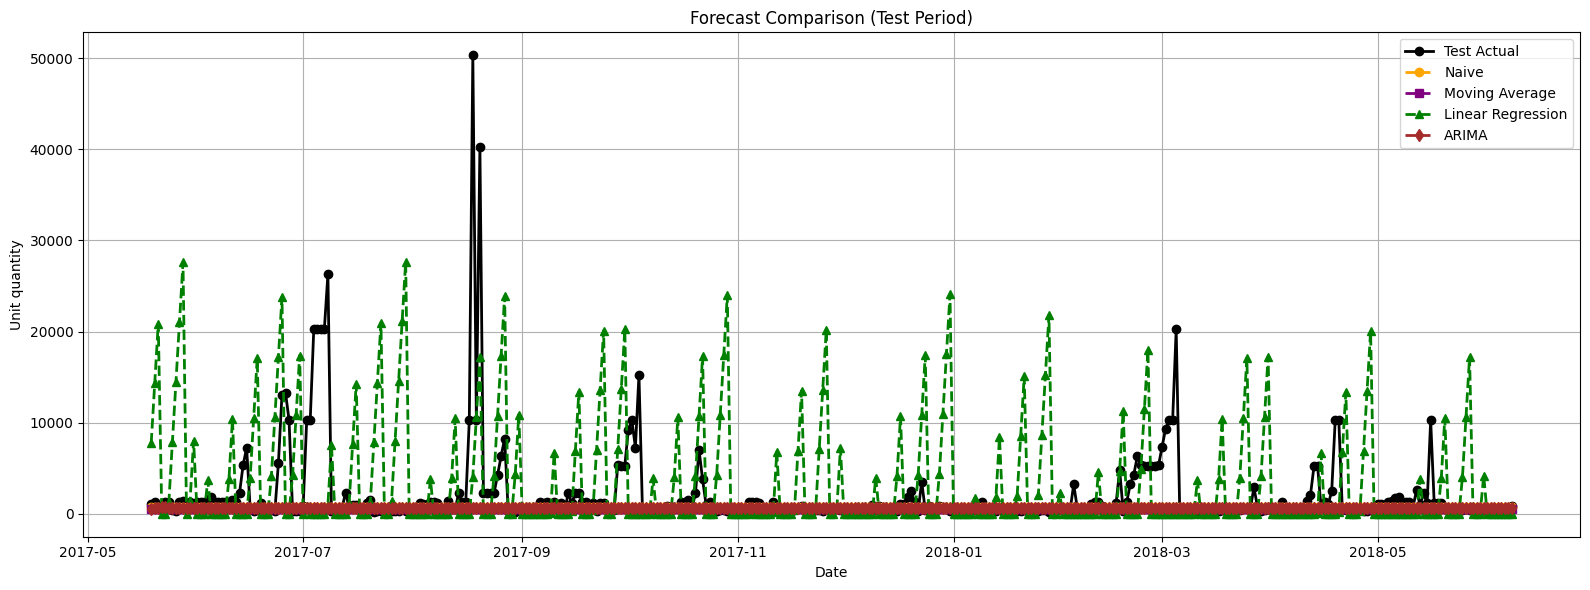

In [115]:
# -------------------- Plot all forecasts --------------------
# -------------------------
# 11. Plot all forecasts
# -------------------------
plt.figure(figsize=(16,6))

# Test actuals
plt.plot(test['Date'], y_test, label='Test Actual', color='black', linewidth=2, marker='o')

# Forecasts
plt.plot(test['Date'], naive_pred, label='Naive', linestyle='--', marker='o', color='orange', linewidth=2)
plt.plot(test['Date'], ma_pred, label='Moving Average', linestyle='--', marker='s', color='purple', linewidth=2)
plt.plot(test['Date'], lr_pred_clipped, label='Linear Regression', linestyle='--', marker='^', color='green', linewidth=2)
plt.plot(test['Date'], arima_pred, label='ARIMA', linestyle='--', marker='d', color='brown', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Unit quantity')
plt.title('Forecast Comparison (Test Period)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
# -------------------- Save predictions --------------------
forecast_df = pd.DataFrame({'Date': test['Date'], 'Actual': test['Unit quantity']})
for model_name, pred in results.items():
    forecast_df[model_name] = pred

forecast_df.to_csv(r"C:\Users\neeno\Downloads\forecast_comparison.csv", index=False)
print("Predictions saved successfully!")

Predictions saved successfully!
